In [17]:
from utils import *
from network import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
weights = load_pretrained_weights()

In [5]:
voxceleb_dataset = VoxCelebDataset(PAIRS_FILE)
train_dataloader = DataLoader(voxceleb_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=4)

print(len(voxceleb_dataset), "training samples", len(voxceleb_dataset.training_users))
# print(voxceleb_dataset.all_user_ids)

3200 training samples 80


In [6]:
model = VggVox(weights=weights)
model = model.to(device)

In [7]:
criterion = ContrastiveLoss()
# criterion = criterion.to(device) 

In [8]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
loss_list = []

In [10]:
def load_saved_model(fname, test=True):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    new_model_dict = VggVox()
    checkpoint_path = get_rel_path(os.path.join(CHECKPOINTS_FOLDER, fname))
    checkpoint = torch.load(checkpoint_path)

    new_model_dict.load_state_dict(checkpoint['state_dict'])
    if test:
        model = new_model_dict.eval()
    model = model.to(device)

    new_optimizer = optim.Adam(params=model.parameters())
    new_optimizer.load_state_dict(checkpoint['optim_dict'])
    epoch = checkpoint['epoch']

    return model, new_model_dict, new_optimizer

In [11]:
checkpoints = os.listdir(get_rel_path('checkpoints/'))
print("\n".join(checkpoints))

checkpoint_20181208-081759_0.14750675857067108.pth.tar
checkpoint_20181208-084522_0.00958214234560728.pth.tar
checkpoint_20181208-090431_0.007160770706832409.pth.tar
checkpoint_20181208-082002_0.025060191750526428.pth.tar
checkpoint_20181208-082817_0.014348131604492664.pth.tar
checkpoint_20181208-083429_0.0120355524122715.pth.tar
checkpoint_20181208-090227_0.007458028383553028.pth.tar
checkpoint_20181208-082206_0.020651986822485924.pth.tar
checkpoint_20181208-083632_0.011468329466879368.pth.tar
checkpoint_20181208-082410_0.018174389377236366.pth.tar
checkpoint_20181208-091042_0.006960536353290081.pth.tar
checkpoint_20181208-091653_0.006890598684549332.pth.tar
checkpoint_20181208-085412_0.00839352235198021.pth.tar
checkpoint_20181208-084801_0.009026485495269299.pth.tar
checkpoint_20181208-085005_0.008921545930206776.pth.tar
checkpoint_20181208-085820_0.008216631598770618.pth.tar
checkpoint_20181208-083225_0.012516533955931664.pth.tar
checkpoint_20181208-083021_0.013070221990346909.pth.t

In [13]:
test_model ,_, _ = load_saved_model('checkpoint_20181208-090431_0.007160770706832409.pth.tar')

### for each user ID get mean embedding 

In [14]:
class VoxCelebTestDataset(Dataset):
    
    def __init__(self, pairs_fname,  training_users, n_users=5, clips_per_user=5):
        pairs_file = pd.read_csv(get_rel_path(pairs_fname))
#         pairs_file['user1'] = pairs_file['path1'].apply(lambda x: x[x.find('/')+1: x.find('_')])
        
        user_subset = pairs_file[pairs_file.user1.isin(training_users)]
        self.test_users =  user_subset.user1.unique()#[:n_users]
        self.spec = user_subset[user_subset.user1.isin(self.test_users)]
        
        self.spec = self.spec.drop_duplicates(subset = ['path1'])[['user1', 'path1']].values  
#         assert len(np.unique((self.spec[:,0]))) == n_users

    def __len__(self):
        return len(self.spec)

    def __getitem__(self, idx):
        spec1_path = get_rel_path(self.spec[idx][1])
        user_id = self.spec[idx][0]
        
        spec1 = np.load(spec1_path)
        
        sample = {'spec': spec1, 'user_id': user_id}

        return sample

In [15]:
test_batch_size = 1
training_users = voxceleb_dataset.training_users
voxceleb_test_dataset = VoxCelebTestDataset(PAIRS_FILE,training_users, clips_per_user = 5, n_users = 10)
test_dataloader = DataLoader(voxceleb_test_dataset, batch_size=test_batch_size, shuffle=False, 
                              num_workers=1)

print(len(voxceleb_test_dataset), "test samples")
print(voxceleb_test_dataset.test_users)

800 test samples
['id10076' 'id10073' 'id10079' 'id10071' 'id10075' 'id10077' 'id10074'
 'id10080' 'id10072' 'id10078' 'id10065' 'id10061' 'id10063' 'id10068'
 'id10062' 'id10069' 'id10070' 'id10066' 'id10064' 'id10067' 'id10058'
 'id10053' 'id10059' 'id10056' 'id10057' 'id10052' 'id10055' 'id10060'
 'id10051' 'id10054' 'id10050' 'id10041' 'id10043' 'id10045' 'id10042'
 'id10049' 'id10046' 'id10047' 'id10044' 'id10048' 'id10040' 'id10038'
 'id10037' 'id10033' 'id10034' 'id10039' 'id10035' 'id10036' 'id10032'
 'id10031' 'id10025' 'id10027' 'id10021' 'id10028' 'id10030' 'id10023'
 'id10029' 'id10022' 'id10026' 'id10024' 'id10019' 'id10020' 'id10015'
 'id10011' 'id10012' 'id10017' 'id10014' 'id10018' 'id10016' 'id10013'
 'id10004' 'id10007' 'id10010' 'id10001' 'id10008' 'id10006' 'id10009'
 'id10002' 'id10003' 'id10005']


In [18]:
def get_user_model(voxceleb_test_dataset = voxceleb_test_dataset):
    user_dict = OrderedDict()

    for i, data in enumerate(voxceleb_test_dataset):
        spec, user_id = data['spec'], data['user_id']
        spec = torch.tensor(spec)
        spec = spec.view(test_batch_size, 1, spec.shape[0], spec.shape[1])
        spec = spec.to(device)
        out = test_model.forward_single(spec)
        out = out.view(out.shape[0], out.shape[1])

        if user_dict.get(user_id, None) is not None:
              user_dict[user_id].append(out.detach().cpu().numpy())
    
        else:
              user_dict[user_id] = [out.detach().cpu().numpy()]

    print("total :", i+1)
    mean_dict = {}
    for user_id, emb_list  in user_dict.items():
        emb_list = np.array(emb_list)
        mean_emb = np.mean(emb_list, axis = 0)
        mean_dict[user_id] = mean_emb

    return user_dict, mean_dict

In [19]:
user_dict, mean_dict = get_user_model()
# dict2 = {k: v.shape for k, v in mean_dict.items()}
# print(dict2)
# s = 0
# for k, v in user_dict.items():
#     s += len(v)
# print(s)

total : 800


In [51]:
# print(np.array(user_dict['id10076']).shape)
# t = np.array(user_dict['id10076'])
# t = t.mean(axis = 0)
# t.shape

###  T-sne

In [20]:
from sklearn.manifold import TSNE

data_list =[]
user_list = []
mean_list = []
counts = 0
user = 0
for user_id, li in user_dict.items():
    user += 1
    for arr in li:
        data_list.append(arr)
        user_list.append(user)
        counts += 1
    mean_list.append(mean_dict[user_id])
    
mean_data = np.vstack(mean_list)
data = np.vstack(data_list)
print(data.shape)
print(counts)



(800, 1024)
800


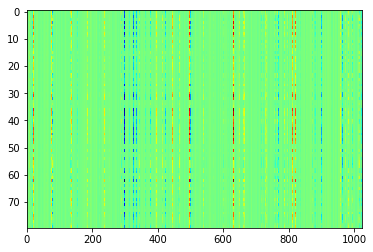

In [21]:
plt.imshow(mean_data, aspect='auto', cmap='jet')

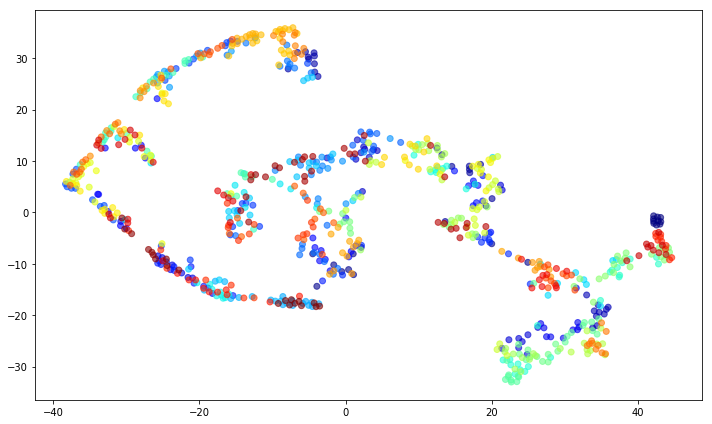

In [48]:
tsne = TSNE(n_components = 2, perplexity = 25)
tsne_embedding = tsne.fit_transform(data)
plt.figure(figsize=(10, 6))
plt.scatter(x= tsne_embedding[:,0], y = tsne_embedding[:, 1], c = user_list, cmap='jet', alpha = 0.6)
plt.tight_layout()

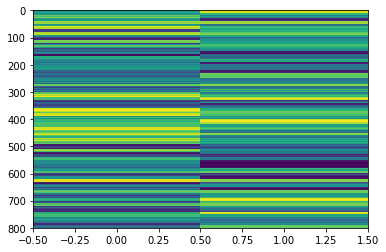

In [46]:
plt.imshow(tsne_embedding, aspect='auto', cmap='viridis')

### test phase

In [ ]:
plt.savefig('')

In [29]:
from sklearn.metrics.pairwise import cosine_similarity 

In [30]:
def get_cosine_similarity(mat1, mat2):
#     mat1 = mat1.cpu().detach().numpy() 
#     mat2 = mat2.cpu().detach().numpy() 
    return cosine_similarity(mat1, mat2)

In [31]:
def get_accuracy(test_dataset, mean_data):

    test_user_embeddings, _ = get_user_model(test_dataset)
    correct, incorrect = 0, 0
    
    for i,j in enumerate(test_user_embeddings):
        user_emb_i = np.vstack(test_user_embeddings[j])
        cosine_similarity = get_cosine_similarity(mean_data, user_emb_i)
        pred = np.argmax(cosine_similarity, axis=1)
        correct_i = (pred==i).sum()
        correct += correct_i
        incorrect += (user_emb_i.shape[0] - correct_i)
    
    print(correct, incorrect)
    
    return correct / (correct + incorrect)   

In [32]:
get_accuracy(voxceleb_test_dataset, mean_data)

total : 800
14 786


0.0175

In [35]:
# get pairs test data, 
test_pairs_file = 'pairs.csv'
voxceleb_test_pairs_dataset = VoxCelebDataset(test_pairs_file)

criterion = ContrastiveLoss()
criterion = criterion.to(device) 

In [36]:
all_losses, all_labels  = [], []

for i, data  in enumerate(voxceleb_test_pairs_dataset):
    
    mfcc1, mfcc2, label = data['spec1'], data['spec2'], data['label']
    mfcc1 = torch.tensor(mfcc1)
    mfcc2 = torch.tensor(mfcc2)
    
    mfcc1 = mfcc1.view(test_batch_size, 1, mfcc1.shape[1], mfcc1.shape[2])
    mfcc2 = mfcc2.view(test_batch_size, 1, mfcc2.shape[1], mfcc2.shape[2])
    mfcc1 = mfcc1.to(device)
    mfcc2 = mfcc2.to(device)

    output1, output2 = model(mfcc1, mfcc2)   
    loss = criterion(output1, output2, label)
        
    all_losses.append(loss.item())
    all_labels.append(label)
    
    print(i, loss.item(), label)
    if i ==10:
        break

threshold = 0.5

idxs = np.where(np.asarray(all_losses) < threshold) 
preds = np.ones(len(all_losses))
preds[idxs] = 0
print(preds)

# positive class = 0, negative = 1
true_positives = np.where(preds[np.where(all_labels == 0)] == 0)
true_negatives = np.where(preds[np.where(all_labels == 1)] == 1)
false_positives = np.where(preds[np.where(all_labels == 1)] == 0)
false_negatives = np.where(preds[np.where(all_labels == 0)] == 1)

# f1 score
precision = len(true_positives) / (len(true_positives) + len(false_positives))
recall = len(true_positives) / (len(true_positives) + len(false_negatives))
f1_score = 2 * precision * recall / (precision + recall)

print("precision", "recall", "F1 score")
print(precision, recall, f1_score)

0 5.778176784515381 0


RuntimeError: CUDA error: out of memory

In [ ]:
a = torch.tensor([[1,2], [3,4]])

In [ ]:
a.shape

In [ ]:
a.view(1,1,1,-1).shape

In [ ]:
all_losses.data